# Baseline Comparisons and Linear Regression for Trend IMF

In [1]:
import gsod
import numpy as np
from matplotlib import pyplot as plt

gsod.enable_svg_graphing()

In [2]:
STATION = "722860"
ds = gsod.GsodDataset("runtime/GSOD")
filled = ds.read_continuous(stn=STATION, year="????", fill="ffill")
filled.describe().T

,count,mean,std,min,25%,50%,75%,max
STN,32354.0,722860.000000,0.000000,722860.0,722860.0,722860.0,722860.0,722860.00
WBAN,32354.0,27460.341411,17746.121157,23119.0,23119.0,23119.0,23119.0,99999.00
TEMP,32354.0,62.576949,11.061889,31.1,53.9,61.5,71.3,105.40
TEMP_COUNT,32354.0,23.368053,2.851843,4.0,24.0,24.0,24.0,24.00
DEWP,32354.0,377.128723,1790.849275,-14.4,37.9,46.5,53.0,9999.90
DEWP_COUNT,32354.0,23.054305,4.409794,0.0,24.0,24.0,24.0,24.00
SLP,32354.0,1108.205622,910.893861,994.3,1012.1,1014.4,1017.6,9999.90
SLP_COUNT,32354.0,18.957223,7.220772,0.0,8.0,24.0,24.0,24.00
STP,32354.0,5616.034051,4517.678520,939.4,960.3,9999.9,9999.9,9999.90
STP_COUNT,32354.0,9.301817,10.872137,0.0,0.0,0.0,24.0,24.00


## Reusing Yesterday's Termperature as Prediction

Text(0, -50, 'MAE: 2.739${}^\\circ$F\nRMSE: 3.547${}^\\circ$F')

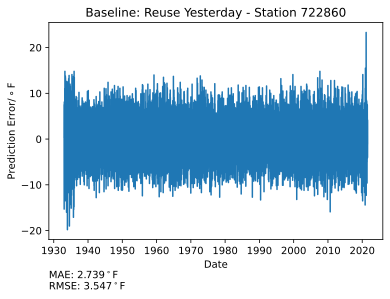

In [3]:
Y = np.asarray(filled["TEMP"])
error = Y[1:] - Y[:-1]
plt.plot(filled.index[1:], error)
plt.xlabel("Date")
plt.ylabel("Prediction Error/${}\circ$F")
plt.title(f"Baseline: Reuse Yesterday - Station {STATION}")
plt.annotate(
    f"MAE: {np.average(np.abs(error)):0.4}${{}}^\circ$F\n"
    + f"RMSE: {np.average(error ** 2) ** 0.5:0.4}${{}}^\circ$F",
    (0, -50),
    xycoords="axes points"
)

In [4]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

X = gsod.sliding_window(np.asarray(filled["TEMP"]), 7)[:-1]
Y = np.asarray(filled["TEMP"])[7:]

lr.fit(X[:20000], Y[:20000])

LinearRegression()

Text(0, -50, 'MAE: 2.603${}^\\circ$F\nRMSE: 3.368${}^\\circ$F')

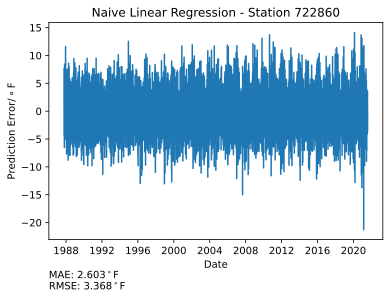

In [5]:
Ypredict = lr.predict(X[20000:])

plt.plot(filled.index[20007:], Ypredict - Y[20000:])
plt.xlabel("Date")
plt.ylabel("Prediction Error/${}\circ$F")
plt.title(f"Naive Linear Regression - Station {STATION}")
plt.annotate(
    f"MAE: {np.average(np.abs(Ypredict - Y[20000:])):0.4}${{}}^\circ$F\n"
    + f"RMSE: {np.average((Ypredict - Y[20000:])**2)**0.5:0.4}${{}}^\circ$F",
    (0, -50),
    xycoords="axes points"
)

Linear regression does not seem to perform well.
However, it is already a better predictor than the baseline. Furthermore, it is also a good predictor for the last IMF.

## Linearly Predict the Last IMF

Text(0, -50, 'MAE: 3.652e-12${}^\\circ$F\nRMSE: 6.011e-12${}^\\circ$F')

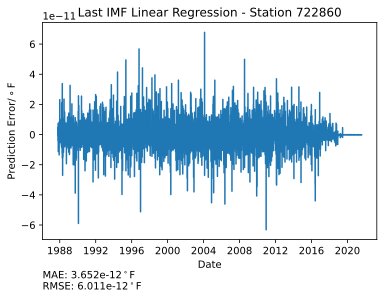

In [6]:
imfs = np.load("runtime/imfs.npy")
lr_last_imf = LinearRegression()
windows = gsod.sliding_window(imfs[-1], 7)[:-1]
Y = imfs[-1][7:]
Xtrain = windows[:20000]
Ytrain = Y[:20000]
lr_last_imf.fit(Xtrain, Ytrain)

error = lr_last_imf.predict(windows[20000:]) - Y[20000:]
plt.plot(filled.index[20007:], error)
plt.xlabel("Date")
plt.ylabel("Prediction Error/${}\circ$F")
plt.title(f"Last IMF Linear Regression - Station {STATION}")
plt.annotate(
    f"MAE: {np.average(np.abs(error)):0.4}${{}}^\circ$F\n"
    + f"RMSE: {np.average(error ** 2) ** 0.5:0.4}${{}}^\circ$F",
    (0, -50),
    xycoords="axes points"
)

Error of $10^{-12}$! Impressive!

In [7]:
import pickle
pickle.dump(lr_last_imf, open("runtime/last_imf_linear.pkl", "wb"))